# Descripción del Ejercicio 
Has recibido una tarea analítica de una tienda en línea internacional. Tus predecesores no consiguieron completarla: lanzaron una prueba A/B y luego abandonaron (para iniciar una granja de sandías en Brasil). Solo dejaron las especificaciones técnicas y los resultados de las pruebas.

# Descripción Técnica 
- Nombre de la prueba: `recommender_system_test`
- Grupos: А (control), B (nuevo embudo de pago)
- Launch date: 2020-12-07
- Fecha en la que dejaron de aceptar nuevos usuarios: 2020-12-21
- Fecha de finalización: 2021-01-01
- Audiencia: 15% de los nuevos usuarios de la región de la UE
- Propósito de la prueba: probar cambios relacionados con la introducción de un sistema de recomendaciones mejorado
- Resultado esperado: dentro de los 14 días posteriores a la inscripción, los usuarios mostrarán una mejor conversión en vistas de la página del producto (el evento `product_page`), instancias de agregar artículos al carrito de compras (`product_card`) y compras (`purchase`). En cada etapa del embudo `product_page → product_card → purchase`, habrá al menos un 10% de aumento.
- Número previsto de participantes de la prueba: 6 000


# Instrucciones a seguir 
- Describe los objetivos del estudio.
- Explora los datos:
    - ¿Es necesario convertir los tipos?
    - ¿Hay valores ausentes o duplicados? Si es así, ¿cómo los caracterizarías?
- Lleva a cabo el análisis exploratorio de datos:
    - Estudia la conversión en las diferentes etapas del embudo.
    - ¿El número de eventos por usuario está distribuido equitativamente entre las muestras?
    - ¿Hay usuarios que están presentes en ambas muestras?
    - ¿Cómo se distribuye el número de eventos entre los días?
    - ¿Hay alguna peculiaridad en los datos que hay que tener en cuenta antes de iniciar la prueba A/B?
- Evaluar los resultados de la prueba A/B:
    - ¿Qué puedes decir sobre los resultados de la prueba A/B?
    - Utiliza una prueba z para comprobar la diferencia estadística entre las proporciones
- Describe tus conclusiones con respecto a la etapa EDA y los resultados de la prueba A/B

# Importar Librerías 


In [93]:
# Librerías para la manipulación de datosm
import pandas as pd 
import numpy as np 
import math 
import datetime as dt 
# Librerías para el estudio estadístico 
from scipy import stats as st 
# Librerías para la visualización de datos  
import seaborn as sns 
import matplotlib.pyplot as plt 

# Importar datasets 

In [94]:
# Calendario de eventos de marketing 
marketing_events = pd.read_csv('ab_project_marketing_events_us.csv')
# Usuarios que se registraron 
users = pd.read_csv('final_ab_new_users_upd_us.csv')
# Evento de los usuarios 
events = pd.read_csv('final_ab_events_upd_us.csv')
# Datos de los participantes de la prueba 
user_data = pd.read_csv('final_ab_participants_upd_us.csv')

# Descripción de los datos 
- `marketing_events`: el calendario de eventos de marketing para 2020
- `users`: todos los usuarios que se registraron en la tienda en línea desde el 7 hasta el 21 de diciembre de 2020
- `events`: todos los eventos de los nuevos usuarios en el período comprendido entre el 7 de diciembre de 2020 y el 1 de enero de 2021
- `user_data`: tabla con los datos de los participantes de la prueba

## Marketing Events 
- `name`: el nombre del evento de marketing
- `regions`: regiones donde se llevará a cabo la campaña publicitaria
- `start_dt`: fecha de inicio de la campaña
- `finish_dt`: fecha de finalización de la campaña

In [95]:
marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


## Users
- `user_id`
- `first_date`: fecha de inscripción
- `region`
- `device`: dispositivo utilizado para la inscripción

In [96]:
users.head(10)

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
5,137119F5A9E69421,2020-12-07,N.America,iPhone
6,62F0C741CC42D0CC,2020-12-07,APAC,iPhone
7,8942E64218C9A1ED,2020-12-07,EU,PC
8,499AFACF904BBAE3,2020-12-07,N.America,iPhone
9,FFCEA1179C253104,2020-12-07,EU,Android


## Events 
- `user_id`
- `event_dt`: fecha y hora del evento
- `event_name`: nombre del tipo de evento
- `details`: datos adicionales sobre el evento (por ejemplo, el pedido total en USD para los eventos `purchase`)

In [97]:
events.head(10)

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
5,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99
6,6B2F726BFD5F8220,2020-12-07 11:27:42,purchase,4.99
7,BEB37715AACF53B0,2020-12-07 04:26:15,purchase,4.99
8,B5FA27F582227197,2020-12-07 01:46:37,purchase,4.99
9,A92195E3CFB83DBD,2020-12-07 00:32:07,purchase,4.99


## User Data 
- `user_id`
- `ab_test`: nombre de la prueba
- `group`: el grupo de prueba al que pertenecía el usuario

In [98]:
user_data.head(10)

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test
5,7473E0943673C09E,A,recommender_system_test
6,C46FE336D240A054,A,recommender_system_test
7,92CB588012C10D3D,A,recommender_system_test
8,B3A2485649E4A012,A,recommender_system_test
9,66FC298441D50783,A,recommender_system_test


# Preprocesamiento de Datos 

## Valores Ausentes 

### Marketing Events 


In [99]:
marketing_events.isna().sum()

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

El dataset no muestra ningún valor ausente 

### Users 

In [100]:
users.isna().sum()

user_id       0
first_date    0
region        0
device        0
dtype: int64

El dataset no muestra ningún valor ausente 

### Events 


In [101]:
events.isna().sum()

user_id            0
event_dt           0
event_name         0
details       363447
dtype: int64

El dataset muestra una gran cantidad de valores ausentes en la columna `details`, sin embargo estos datos solamente dan información adicional para los diferentes eventos del dataset y el eliminarlos nos haría perder información muy importante para el estudio del embudo, por lo que no se eliminarán 

### User Data


In [102]:
user_data.isna().sum()

user_id    0
group      0
ab_test    0
dtype: int64

El dataset no muestra ningún valor ausente 

## ¿Es necesario convertir los datos?


Utilizar la información general de los datasets para ver el tipo de datos actuales y tomar decisiones en base a el

### Marketing Events


In [103]:
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 580.0+ bytes


Las columnas referentes a las fechas de inicio y final deberían ser tipo datetime, pero son de tipo object y por esa razón se pasarán a tipo datetime

In [104]:
# Convertir a tipo datetime
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])

### Users

In [105]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [106]:
# Convertir a tipo datetime 
users['first_date'] = pd.to_datetime(users['first_date'])

### Events 

In [107]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB


In [108]:
# Convertir a tipo datetime 
events['event_dt'] = pd.to_datetime(events['event_dt'])

### User Data 

In [109]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB


## Valores Duplicados 



### Marketing Events 


In [110]:
marketing_events.duplicated().sum()

0

### Users 

In [111]:
users.duplicated().sum()

0

### Events 

In [112]:
events.duplicated().sum()

0

### User Data 


In [113]:
user_data.duplicated().sum()

0

# Análisis Exploratorio de Datos 
Antes de iniciar este analisis exploratorio, es importante crear un dataframe que contenga toda la informacion de los usuarios, para ello ocuparemos los df 'users', 'events' y 'user_data'

## Unir la info de todos los usuarios en un solo DF

In [134]:
test_data = users.merge(events, on='user_id', how='left').merge(user_data, on='user_id', how='left')
# Ver Informacion General 
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429476 entries, 0 to 429475
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     429476 non-null  object        
 1   first_date  429476 non-null  datetime64[ns]
 2   region      429476 non-null  object        
 3   device      429476 non-null  object        
 4   event_dt    429476 non-null  datetime64[ns]
 5   event_name  429476 non-null  object        
 6   details     61134 non-null   float64       
 7   date        429476 non-null  datetime64[ns]
 8   group       102838 non-null  object        
 9   ab_test     102838 non-null  object        
dtypes: datetime64[ns](3), float64(1), object(6)
memory usage: 32.8+ MB


Vemos que el DF resultante tiene demasiados valores ausentes en las columnas referentes a la prueba A/B, como lo son: 'group' y 'ab_test', por lo que se eliminaran los valores ausentes de estas columnas ya que son de usuarios que no estan registrados en ningun grupo de la prueba

In [135]:
test_data.dropna(subset='group', inplace=True)

Antes de continuar es importante separar el DF en los grupos A y B para poder hacer comparaciones entre ambos y valorar los resultados de la prueba A/B 

In [137]:
# Separar el DF en los dos grupos 

group_A = test_data[test_data['group']=='A'] # Filtrar los datos con la informacion de los usuarios del grupo A
group_B = test_data[test_data['group']=='B'] # Filtrar los datos con la informacion de los usuarios del grupo B

## Conversión en las diferentes etapas del embudo 

In [149]:
# Ver los eventos posibles 
print(test_data['event_name'].unique())

['product_page' 'login' 'product_cart' 'purchase']


Los 4 eventos registrados son:
+ Login
+ Product Page   
+ Product Cart 
+ Purchase 

El sentido logico del embudo seria el siguiente:

Los usuarios al llegar por primera vez van a la pagina 'Login', luego de registrarse o iniciar sesion van a 'Product Page', en el caso que les agrade un producto agregan este al carrito, por lo que la siguiente etapa del embudo es en 'Product Cart' y por ultimo la pagina 'Purchase'. Esto nos deja un total de 3 etapas en el embudo

In [155]:
'''  
Para calcular la conversion en las diferentes etapas es necesario saber cuantos usuarios se han registrado en cada evento. 
Agruparemos los datos para ambas muestras y calcularemos los usuarios unicos registrados. 
'''
# Calcular los usuarios por evento del grupo A 
user_per_event_A = group_A.groupby('event_name', as_index=False)['user_id'].nunique().sort_values(by='user_id',ascending=False)
# Renombrar columnas  
user_per_event_A.columns = ['event_name','users_count']
# Calcular los usuarios por evento del grupo B 
user_per_event_B = group_B.groupby('event_name', as_index=False)['user_id'].nunique().sort_values(by='user_id',ascending=False)
# Renombrar columnas 
user_per_event_B.columns = ['event_name','users_count']

### Conversion en las etapas del embudo en el grupo A

In [170]:
login_to_product_A = round((int(user_per_event_A['users_count'][user_per_event_A['event_name']=='product_page']) / int(user_per_event_A['users_count'][user_per_event_A['event_name']=='login']))*100,2)
product_to_cart_A = round((int(user_per_event_A['users_count'][user_per_event_A['event_name']=='product_cart']) / int(user_per_event_A['users_count'][user_per_event_A['event_name']=='product_page']))*100,2)
cart_to_purchase_A = round((int(user_per_event_A['users_count'][user_per_event_A['event_name']=='purchase']) / int(user_per_event_A['users_count'][user_per_event_A['event_name']=='product_cart']))*100,2)

C:\Users\User\AppData\Local\Temp\ipykernel_10032\4211925170.py:1: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  login_to_product_A = round((int(user_per_event_A['users_count'][user_per_event_A['event_name']=='product_page']) / int(user_per_event_A['users_count'][user_per_event_A['event_name']=='login']))*100,2)
C:\Users\User\AppData\Local\Temp\ipykernel_10032\4211925170.py:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  product_to_cart_A = round((int(user_per_event_A['users_count'][user_per_event_A['event_name']=='product_cart']) / int(user_per_event_A['users_count'][user_per_event_A['event_name']=='product_page']))*100,2)
C:\Users\User\AppData\Local\Temp\ipykernel_10032\4211925170.py:3: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Us

In [171]:
login_to_product_A, product_to_cart_A, cart_to_purchase_A

(66.15, 47.68, 108.01)

### Conversion en las etapas del embudo en el grupo B

In [168]:
login_to_product_B = round((int(user_per_event_B['users_count'][user_per_event_B['event_name']=='product_page']) / int(user_per_event_B['users_count'][user_per_event_B['event_name']=='login'])) * 100,2)
product_to_cart_B = round((int(user_per_event_B['users_count'][user_per_event_B['event_name']=='product_cart']) / int(user_per_event_B['users_count'][user_per_event_B['event_name']=='product_page'])) * 100,2)
cart_to_purchase_B = round((int(user_per_event_B['users_count'][user_per_event_B['event_name']=='purchase']) / int(user_per_event_B['users_count'][user_per_event_B['event_name']=='product_cart'])) * 100,2)

C:\Users\User\AppData\Local\Temp\ipykernel_10032\4162439894.py:1: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  login_to_product_B = round((int(user_per_event_B['users_count'][user_per_event_B['event_name']=='product_page']) / int(user_per_event_B['users_count'][user_per_event_B['event_name']=='login'])) * 100,2)
C:\Users\User\AppData\Local\Temp\ipykernel_10032\4162439894.py:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  product_to_cart_B = round((int(user_per_event_B['users_count'][user_per_event_B['event_name']=='product_cart']) / int(user_per_event_B['users_count'][user_per_event_B['event_name']=='product_page'])) * 100,2)
C:\Users\User\AppData\Local\Temp\ipykernel_10032\4162439894.py:3: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future

In [172]:
login_to_product_B, product_to_cart_B, cart_to_purchase_B

(64.25, 51.1, 98.58)

## Eventos por usuario 


In [188]:
# Calcular los eventos de cada usuario en el grupo A
event_per_user_A = group_A.groupby('user_id')['event_name'].count().reset_index()
# Calcular los eventos de cada usuario en el grupo B
event_per_user_B = group_B.groupby('user_id')['event_name'].count().reset_index()

In [194]:
# Ver estadisticas descriptivas de los eventos por usuario del grupo A 
event_per_user_A.describe()

,event_name
count,7874.000000
mean,7.455550
std,4.475159
min,1.000000
25%,4.000000
50%,6.000000
75%,9.000000
max,40.000000


In [195]:
# Ver estadisticas descriptivas de los eventos por usuario del grupo B
event_per_user_B.describe()

,event_name
count,6205.000000
mean,7.112490
std,4.246201
min,1.000000
25%,4.000000
50%,6.000000
75%,9.000000
max,36.000000


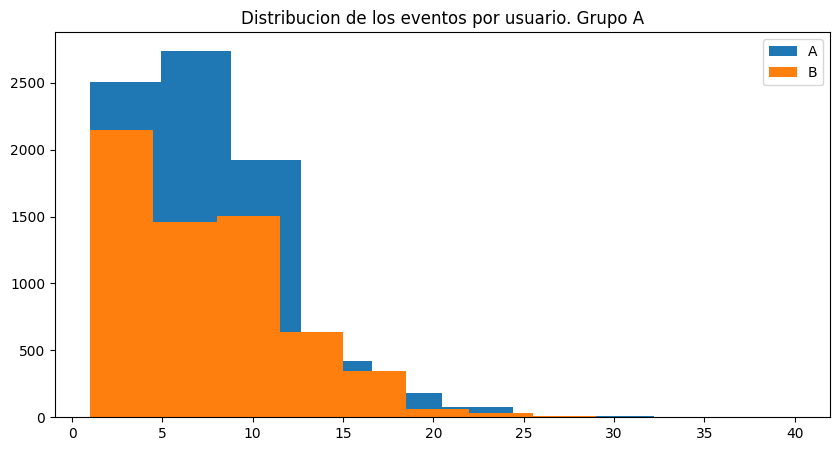

In [190]:
plt.figure(figsize=(10,5))
plt.hist(event_per_user_A['event_name'], label='A')
plt.hist(event_per_user_B['event_name'], label='B')
plt.title('Distribucion de los eventos por usuario. Grupo A')
plt.legend()
plt.show()

## ¿Hay usuarios que están presentes en ambas muestras?

In [198]:
double_group = test_data.groupby('user_id')['group'].nunique().sort_values(ascending=False)

In [201]:
double_group.index[double_group==2]

Index(['B06B45B7C3E5E721', 'E594B711ADD81DD8', 'A8C25A605F613665',
       '3A6D88AB973BD99D', '0ADFFFE9C0D60092', '8BD80DB1522F7120',
       'C89E24F4C723CEF4', 'A8C57C0D4118F4D7', '5A47441C0AC5FAEE',
       '0B0D84A866817D84',
       ...
       '9E68AB5C5C7FEFF4', 'BD31CABB6D5C6561', '4803D52DB8782CC2',
       '23F10CDFF7372B06', '5D72D0AEF96C50FD', 'BAAEE6D68FB90D22',
       '4409E20FCD07CD14', 'C1E43A9B1D675927', 'D9C92EC5F9478381',
       '83E9CFC64D61108E'],
      dtype='object', name='user_id', length=441)

In [212]:
r = group_A.groupby('date', as_index=False).agg({'event_name':'count'})

In [213]:
r

,date,event_name
0,2020-12-07,1375
1,2020-12-08,1493
2,2020-12-09,1557
3,2020-12-10,1638
4,2020-12-11,1672
5,2020-12-12,2173
6,2020-12-13,2335
7,2020-12-14,3582
8,2020-12-15,3294
9,2020-12-16,3179
